In [81]:
import os 
import sqlalchemy
import psycopg2
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt


pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [244]:
%run my_module.ipynb

In [4]:
user = os.environ.get('pyb_user')
pass_ = os.environ.get('pyb_psw')


In [5]:
metrics = ['order_defect_value_short_term',
 'cancellation_orders_short_term',
 'cancellation_value_short_term',
 'late_shipment_orders_short_term',
 'late_shipment_value_short_term',
 'order_defect_orders_short_term',
 'cust_complaints_intelectual_prop',
 'cust_complaints_policy_violation',
 'cust_complaints_prod_authenticity',
 'cust_complaints_prod_safety',
 'a_to_z_guarantee_claims_orders_short_term',
 'a_to_z_guarantee_claims_value_short_term',
 'chargeback_claims_orders_short_term',
 'chargeback_claims_value_short_term',
 'negative_feedback_orders_short_term',
 'negative_feedback_value_short_term',
 'account_status',
 'cancellation_rate',
 'late_shipment_rate',
 'order_defect_rate']

cls = list(chain(*[['create_ts', 'week'], metrics]))

cut_date = '2018-01-01'
sql = "select mp_sup_key, {}, {} from marketplace_ext_data where date(create_ts) >= '{}'".format('date(create_ts)', ", ".join(metrics), cut_date)
print(sql)

select mp_sup_key, date(create_ts), order_defect_value_short_term, cancellation_orders_short_term, cancellation_value_short_term, late_shipment_orders_short_term, late_shipment_value_short_term, order_defect_orders_short_term, cust_complaints_intelectual_prop, cust_complaints_policy_violation, cust_complaints_prod_authenticity, cust_complaints_prod_safety, a_to_z_guarantee_claims_orders_short_term, a_to_z_guarantee_claims_value_short_term, chargeback_claims_orders_short_term, chargeback_claims_value_short_term, negative_feedback_orders_short_term, negative_feedback_value_short_term, account_status, cancellation_rate, late_shipment_rate, order_defect_rate from marketplace_ext_data where date(create_ts) >= '2018-01-01'


In [6]:
%time
data = get_postgress_data(user=user, password=pass_, query=sql, col_index = 'date')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [7]:
print(data.shape)
print(data.head())

(686786, 21)
                                      mp_sup_key  \
date                                               
2018-07-13  3e794632-7e64-4778-9560-4530df94d088   
2018-07-15  971c0e24-eb9a-4868-afd2-e75fa5961f6f   
2018-07-15  814d43d1-1946-4141-a561-200d6114608d   
2018-07-15  c2ed2398-1c8d-4d05-b677-5dda35241094   
2018-07-15  8cd0a83f-8943-435e-8045-f9c1dd5e0974   

            order_defect_value_short_term  cancellation_orders_short_term  \
date                                                                        
2018-07-13                            0.0                           252.0   
2018-07-15                            0.0                            15.0   
2018-07-15                            0.0                            18.0   
2018-07-15                            0.0                             3.0   
2018-07-15                            0.0                            25.0   

            cancellation_value_short_term  late_shipment_orders_short_term  \
date

In [8]:
cls_to_stay = data.columns[~data.columns.str.contains('term')]
cls_to_stay

Index(['mp_sup_key', 'cust_complaints_intelectual_prop',
       'cust_complaints_policy_violation', 'cust_complaints_prod_authenticity',
       'cust_complaints_prod_safety', 'account_status', 'cancellation_rate',
       'late_shipment_rate', 'order_defect_rate'],
      dtype='object')

In [9]:
data.index = pd.to_datetime(data.index)
date_filter = data.index.weekofyear.isin(range(20,41))

In [10]:
df = data.loc[date_filter, cls_to_stay]

In [11]:
df.shape

(278033, 9)

In [12]:
df.rename_axis('date_idx', inplace=True)

In [13]:
df.sort_values(['mp_sup_key', 'date_idx'], inplace = True)


In [14]:
#check for null values
agg_null = transform_for_NaN_values(data = df, cls=cls_to_stay)
agg_null = agg_null.groupby(agg_null.index.weekofyear).mean()

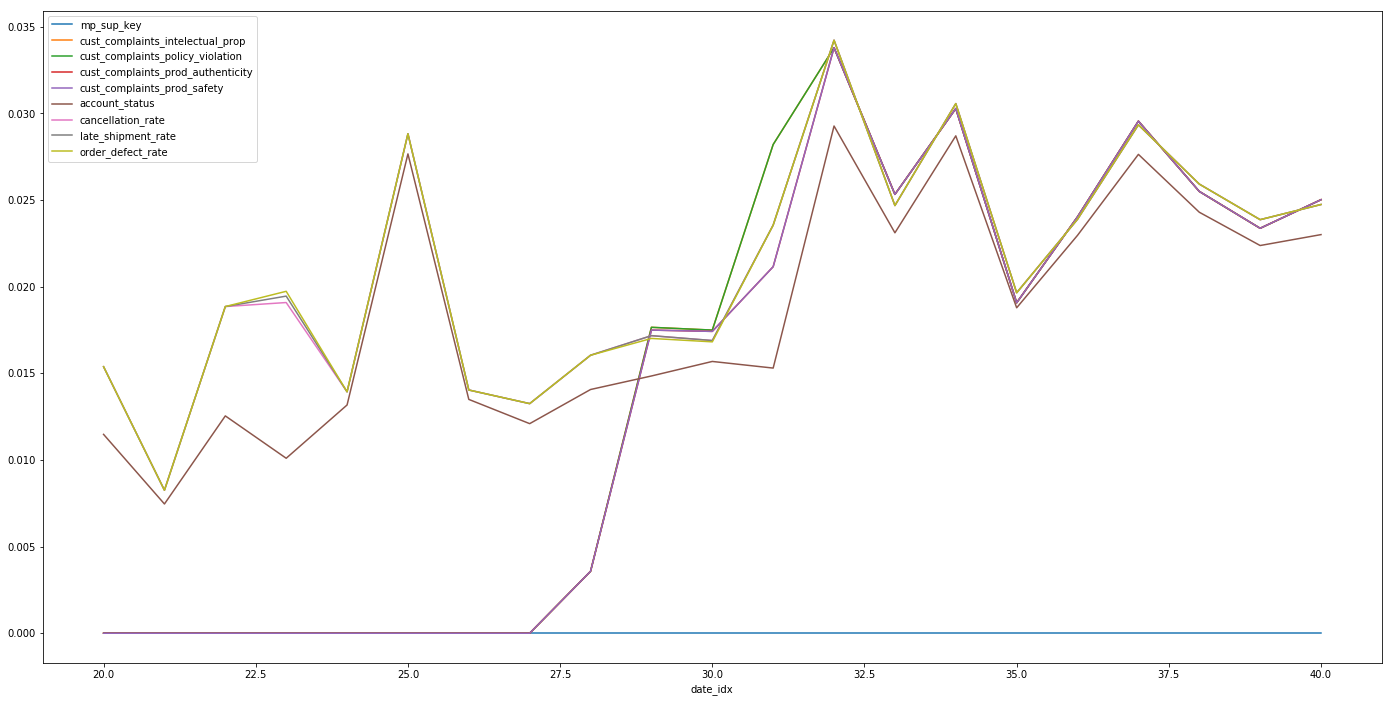

In [15]:
%matplotlib inline
agg_null.plot(figsize=(24,12))

In [16]:
# check for correlations

df.corr().style.background_gradient().set_precision(2)

,cust_complaints_intelectual_prop,cust_complaints_policy_violation,cust_complaints_prod_authenticity,cust_complaints_prod_safety,cancellation_rate,late_shipment_rate,order_defect_rate
cust_complaints_intelectual_prop,1,-0.0018,0.011,0.028,-0.0012,0.0013,-0.0028
cust_complaints_policy_violation,-0.0018,1,0.043,0.03,-0.0027,0.0032,0.0059
cust_complaints_prod_authenticity,0.011,0.043,1,0.22,-0.004,-0.0065,0.0026
cust_complaints_prod_safety,0.028,0.03,0.22,1,-0.0019,0.0094,0.012
cancellation_rate,-0.0012,-0.0027,-0.004,-0.0019,1,0.034,0.013
late_shipment_rate,0.0013,0.0032,-0.0065,0.0094,0.034,1,0.081
order_defect_rate,-0.0028,0.0059,0.0026,0.012,0.013,0.081,1


In [17]:
df.describe()

,cust_complaints_intelectual_prop,cust_complaints_policy_violation,cust_complaints_prod_authenticity,cust_complaints_prod_safety,cancellation_rate,late_shipment_rate,order_defect_rate
count,273843.000000,273843.000000,273940.000000,273940.000000,272107.000000,272103.000000,272103.000000
mean,0.555347,0.000818,0.088833,0.041509,0.638602,1.595952,0.480855
std,8.768952,0.028589,0.439214,0.290307,5.293738,7.856776,2.725903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000
max,632.000000,1.000000,10.000000,7.000000,114.290000,100.000000,180.000000


In [18]:
df.dropna(inplace=True)

In [20]:
df.to_csv('df_check.csv')

In [21]:
df.account_status.unique()

array(['OK', 'At Risk', 'At risk', 'Suspended'], dtype=object)

In [22]:
df['account_status'] = df.account_status.str.lower()

In [23]:
account_mapping = {'ok' : 0, 'at risk' :1, 'suspended' : 2}

In [24]:
df['status'] = df.account_status.map(account_mapping)

In [25]:
df.status.unique()

array([0, 1, 2])

In [26]:
status_prop = df.groupby('mp_sup_key')['status'].max()

In [27]:
status_prop.value_counts()

0    1742
1     737
2     389
Name: status, dtype: int64

## Feature creation


In [30]:
df_suspended = return_transformed_data(df=df, days=14, status=2)

In [31]:
df_at_risk = return_transformed_data(df=df, days=14, status=1)

In [34]:
print(df_at_risk.shape)
print(df_suspended.shape)

(239, 18)
(200, 18)


In [36]:
df_at_risk.head()

,date_idx,cust_complaints_intelectual_prop mean,cust_complaints_intelectual_prop max,cust_complaints_policy_violation mean,cust_complaints_policy_violation max,cust_complaints_prod_authenticity mean,cust_complaints_prod_authenticity max,cust_complaints_prod_safety mean,cust_complaints_prod_safety max,cancellation_rate mean,cancellation_rate max,late_shipment_rate mean,late_shipment_rate max,order_defect_rate mean,order_defect_rate max,status,mp_sup_key,lag_status
75,2018-08-18,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.158095,4.88,0.0,0.0,0.000000,0.00,0.0,000b068c-69b3-426e-a506-9914eaf8710b,1.0
319,2018-09-02,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.738571,0.87,0.0,017767c0-d637-4bc9-94c9-36a4af81cd82,1.0
477,2018-07-20,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175714,0.68,0.0,0.0,0.118571,0.17,0.0,029510aa-73ac-48b8-b064-83846febc656,1.0
1205,2018-09-18,2.761905,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591429,2.33,0.0,0.0,0.066190,0.39,0.0,03ab9bac-04b4-44e8-b7cb-3c196fb09867,1.0
1510,2018-07-12,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.285714,100.00,0.0,0.0,0.000000,0.00,0.0,044c1761-dae3-407b-a1f5-ba3fec587a89,1.0


In [42]:
df_at_risk.describe()

,cust_complaints_intelectual_prop mean,cust_complaints_intelectual_prop max,cust_complaints_policy_violation mean,cust_complaints_policy_violation max,cust_complaints_prod_authenticity mean,cust_complaints_prod_authenticity max,cust_complaints_prod_safety mean,cust_complaints_prod_safety max,cancellation_rate mean,cancellation_rate max,late_shipment_rate mean,late_shipment_rate max,order_defect_rate mean,order_defect_rate max,status,lag_status
count,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000
mean,1.064,1.494,0.000,0.000,0.063,0.071,0.017,0.017,0.673,3.409,1.076,3.339,0.250,0.374,0.000,1.000
std,12.756,19.064,0.000,0.000,0.254,0.273,0.129,0.129,2.060,11.715,2.579,11.153,0.323,0.423,0.000,0.000
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.200,0.000,1.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.463,2.060,1.259,2.915,0.456,0.750,0.000,1.000
max,196.000,294.000,0.000,0.000,2.000,2.000,1.000,1.000,14.286,100.000,19.752,100.000,1.321,1.430,0.000,1.000


In [43]:
df_suspended.describe()

,cust_complaints_intelectual_prop mean,cust_complaints_intelectual_prop max,cust_complaints_policy_violation mean,cust_complaints_policy_violation max,cust_complaints_prod_authenticity mean,cust_complaints_prod_authenticity max,cust_complaints_prod_safety mean,cust_complaints_prod_safety max,cancellation_rate mean,cancellation_rate max,late_shipment_rate mean,late_shipment_rate max,order_defect_rate mean,order_defect_rate max,status,lag_status
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,0.838,0.930,0.005,0.005,0.307,0.365,0.107,0.120,0.692,3.680,2.263,5.405,1.050,1.424,0.375,2.000
std,2.638,2.927,0.071,0.071,0.701,0.771,0.404,0.432,1.683,10.945,8.227,16.206,3.266,4.250,0.485,0.000
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.085,0.138,0.000,2.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.025,0.365,0.580,0.000,2.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.433,1.927,1.106,2.353,0.927,1.305,1.000,2.000
max,23.000,24.000,1.000,1.000,5.000,5.000,2.667,3.000,10.364,100.000,100.000,100.000,38.786,50.850,1.000,2.000


In [249]:
df_ok = return_transformed_data_good_sup(df, sample = 500)

In [257]:
df_ok.lag_status.fillna(0, inplace=True)

In [258]:
dataset = pd.concat([df_ok, df_at_risk, df_suspended])

In [260]:
dataset.head(10)

,date_idx,cust_complaints_intelectual_prop mean,cust_complaints_intelectual_prop max,cust_complaints_policy_violation mean,cust_complaints_policy_violation max,cust_complaints_prod_authenticity mean,cust_complaints_prod_authenticity max,cust_complaints_prod_safety mean,cust_complaints_prod_safety max,cancellation_rate mean,cancellation_rate max,late_shipment_rate mean,late_shipment_rate max,order_defect_rate mean,order_defect_rate max,status,mp_sup_key,lag_status
67,2018-09-24,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,2.199,7.690,0.000,0.000,0.000,0.000,0.000,2ac161ad-f226-4c18-b10e-d20eba43e03f,0.000
194,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.030,0.320,0.000,69159195-0269-45cf-8a89-d4c6691cf47d,0.000
321,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2ae88c06-d6f6-4055-bd72-a1252fe5a21d,0.000
446,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8a2c1a9b-85c8-4832-8a63-d2a9ba1ae2d7,0.000
571,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6910b3e2-4bcb-44dd-92ee-5a6cd7f235d5,0.000
19016,2018-06-20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c3e72339-6750-4790-907f-864abc5c53b0,0.000
1101,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5f3505ca-9c30-4879-b085-347bf3471e56,0.000
851,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9f0782f4-5f2e-4b58-9ef8-f55aa211a5bc,0.000
975,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,95de0e65-983f-43e6-abf8-536fad632387,0.000
1101,2018-09-24,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5f3505ca-9c30-4879-b085-347bf3471e56,0.000


In [261]:
dataset.lag_status.value_counts()

0.000    365
1.000    239
2.000    200
Name: lag_status, dtype: int64

In [262]:
dataset.to_csv('dateset.csv')

In [265]:
dataset.groupby('lag_status').mean()

,cust_complaints_intelectual_prop mean,cust_complaints_intelectual_prop max,cust_complaints_policy_violation mean,cust_complaints_policy_violation max,cust_complaints_prod_authenticity mean,cust_complaints_prod_authenticity max,cust_complaints_prod_safety mean,cust_complaints_prod_safety max,cancellation_rate mean,cancellation_rate max,late_shipment_rate mean,late_shipment_rate max,order_defect_rate mean,order_defect_rate max,status
lag_status,,,,,,,,,,,,,,,
0.000,0.531,0.545,0.000,0.000,0.040,0.041,0.006,0.008,0.309,1.785,0.214,0.554,0.080,0.135,0.000
1.000,1.064,1.494,0.000,0.000,0.063,0.071,0.017,0.017,0.673,3.409,1.076,3.339,0.250,0.374,0.000
2.000,0.838,0.930,0.005,0.005,0.307,0.365,0.107,0.120,0.692,3.680,2.263,5.405,1.050,1.424,0.375
